# Use PyPSA for a network

This example aims at proposing a sample optimization using PyPSA for a sector-coupled network with the following sources:
- diesel
- solar
- wind

In this example, we reproduce the same example as for the microgrid optimization but with a sector-coupled implementation of the model.
In particular, the diesel generator is represented as a c

## Package imports

Section to first import the major packages used in the notebook.
Note: the PyPSA-Earth environment is suitable to run this notebook.

In [46]:
# package to handle efficient numeric structures (vectors/matrices) mathematical operations
import numpy as np
# package to handle databases, e.g. tabular data
import pandas as pd
# energy modelling package
import pypsa
# package to make plots
import matplotlib.pyplot as plt

Some global constants used for simplifying the code

In [47]:
# figure size
FIGSIZE = (5, 2.5)
# solver of the optimization
SOLVER = "gurobi"
# gps coordinates of the buses
x, y = 33.6208, 1.7250
# set random seed for reproducibility
np.random.seed(0)

## 1. Data import

### PV

The available PV production for every hour of 2019 is estimated using Renewables.ninja platform, using standard inputs for the PV plant (tilt angle, orientation, etc.).
The data are downloaded manually and loaded into the data folder with name `ninja_pv_1.7250_33.6208_uncorrected.csv`.

In the following, the file is loaded also including some plottings for easy visualization.

In [48]:
# file name of the pv data
pv_file = '../microgrid_optimization/data/ninja_pv_1.7250_33.6208_uncorrected.csv'

# Load the CSV file
df_pv = pd.read_csv(pv_file, skiprows=3)  # skip the first 3 rows
df_pv.rename(columns={'electricity': 'pv'}, inplace=True)  # rename the electricity column

### Wind

The available wind production for every hour of 2019 is estimated using Renewables.ninja platform, using standard inputs for the PV plant (tilt angle, orientation, etc.).
The data are downloaded manually and loaded into the data folder with name `ninja_wind_1.7250_33.6208_uncorrected.csv`.

In the following, the file is loaded also including some plottings for easy visualization.

In [49]:
# file name of the pv data
wind_file = '../microgrid_optimization/data/ninja_wind_1.7250_33.6208_uncorrected.csv'

# Load the CSV file
df_wind = pd.read_csv(wind_file, skiprows=3)  # skip the first 3 rows
df_wind.rename(columns={'electricity': 'wind'}, inplace=True)  # rename the electricity column

### Electricity load

The load demand is obtained from the paper by D.Fioriti et al.

In the activity, a so-called 'typical daily' profile was estimated using the tool LoadProGen, now available as [RAMP](https://rampdemand.org/).

In the data folder, the file `demand_data.csv` contains the following two columns:
1. the first column is the average demand for every hour of the day
2. the second column is the standard deviation of the demand for every hour of the day

In [50]:
# file name of the pv data
demand_file = '../microgrid_optimization/data/demand_data.csv'

# Load the CSV file
df_demand_day = pd.read_csv(demand_file)
df_demand_day["hour"] = range(0, 24)

confidence_factor = 1.96  # 95% confidence interval

We generate year-long demand data by randomly sampling from a normal distribution with the mean and standard deviation for every hour of the day, similarly to the example for microgrid optimization.

In [51]:
n_days = 365  # number of days to simulate

df_demand = pd.DataFrame(index=df_pv.index)

df_demand_year = np.random.normal(
    np.tile(df_demand_day["demand"], n_days),
    np.tile(df_demand_day["standard_deviation"], n_days),
)
df_demand.loc[:, "elec_demand"] = df_demand_year

## Heating and cooling load

The heating and cooling load is obtained from renewables.ninja platform, using the same location and parameters as for the PV and wind data.
The data are downloaded manually and loaded into the data folder with name `ninja_demand_1.7250_33.6208_uncorrected.csv`.

In [52]:
demand_heatcool_file = '../microgrid_optimization/data/ninja_demand_1.7250_33.6208_uncorrected.csv'


df_heat_cool = pd.read_csv(demand_heatcool_file, skiprows=3)  # skip the first 3 rows

df_heat_cool.head(5)

,time,local_time,total_demand,heating_demand,cooling_demand
0,2019-01-01 00:00,2019-01-01 03:00,0.392,0,0.392
1,2019-01-01 01:00,2019-01-01 04:00,0.346,0,0.346
2,2019-01-01 02:00,2019-01-01 05:00,0.310,0,0.310
3,2019-01-01 03:00,2019-01-01 06:00,0.279,0,0.279
4,2019-01-01 04:00,2019-01-01 07:00,0.259,0,0.259


For simplicity, all time series data are now aggregated into a single dataframe for simplicity

In [53]:
# merge the data into one dataframe
df_data = pd.concat(
    [df_pv[["pv"]], df_wind[["wind"]], df_demand, df_heat_cool[["heating_demand", "cooling_demand"]]],
    axis=1,
)

# example constant heating demand
df_data["heating_demand"] = 10

## 2. Create input cost parameters

This section aims at describing the cost parameters used in the optimization.

To do so, the goal is to create a dataframe of major input parameters, for each technology, including:
- **CAPEX**: capital expenditure
- **OPEX**: operational expenditure, divided into two independent components:
    - ***Fixed* OPEX**: expenditure *independent* from the energy production
    - ***Marginal* OPEX**: expenditure *dependent* from the energy production
- **Lifetime**: lifetime of the technology
- **Efficiency**: efficiency of the technology
- **Discount rate**: discount rate of the analysis

In [54]:
# Initialize the dataframe: columns indicate cost components and rows indicate technologies
assumptions = pd.DataFrame(
    columns=["CAPEX", "discount rate", "efficiency", "OPEX_fixed", "OPEX_marginal", "lifetime"],
    index=["default", "pv", "wind", "battery", "diesel"],
)

# default parameters
assumptions.at["default", "OPEX_fixed"] = 3.0
assumptions.at["default", "OPEX_marginal"] = 0.0
assumptions.at["default", "discount rate"] = 0.08
assumptions.at["default", "lifetime"] = 20

# pv technology
assumptions.at["pv", "CAPEX"] = 900  # EUR/kWp
assumptions.at["pv", "OPEX_fixed"] = 16  # EUR/kWp/year
assumptions.at["pv", "lifetime"] = 25  # years

# wind technology
assumptions.at["wind", "CAPEX"] = 2400  # EUR/kWp
assumptions.at["wind", "OPEX_fixed"] = 80  # EUR/kWp/year
assumptions.at["wind", "lifetime"] = 20  # years

# battery technology
assumptions.at["battery", "CAPEX"] = 450  # EUR/kWh
assumptions.at["battery", "OPEX_fixed"] = 3  # EUR/kWh/year
assumptions.at["battery", "efficiency"] = 0.9  # [-] per unit
assumptions.at["battery", "lifetime"] = 10  # years

# diesel technology
fuel_price = 1.4  # EUR/l
fuel_energy_density = 10  # kWh/l
efficiency_diesel = 0.33  # [-] per unit
efficiency_diesel_CHP = 0.4  # [-] per unit

maintenance_diesel = 0.05  # EUR/kW/h

assumptions.at["diesel", "CAPEX"] = 6e2  # EUR/kW
assumptions.at["diesel", "OPEX_marginal"] = maintenance_diesel  # EUR/kWh
assumptions.at["diesel", "lifetime"] = 3  # years

# fill defaults
assumptions = assumptions.fillna(
    {
        "OPEX_fixed": assumptions.at["default", "OPEX_fixed"],
        "OPEX_marginal": assumptions.at["default", "OPEX_marginal"],
        "discount rate": assumptions.at["default", "discount rate"],
        "lifetime": assumptions.at["default", "lifetime"],
    }
)

# save to file
assumptions.to_csv("assumptions.csv")

assumptions

C:\Users\Davide\AppData\Local\Temp\ipykernel_37632\1494685771.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  assumptions = assumptions.fillna(


,CAPEX,discount rate,efficiency,OPEX_fixed,OPEX_marginal,lifetime
default,NaN,0.08,NaN,3.0,0.00,20
pv,900,0.08,NaN,16.0,0.00,25
wind,2400,0.08,NaN,80.0,0.00,20
battery,450,0.08,0.9,3.0,0.00,10
diesel,600.0,0.08,NaN,3.0,0.05,3


The objective of the system is to minimize the annualized costs, which are computed as follows:

$$
\text{Annualized costs} = OPEX + \sum_{i \in A} {CRF}_i * {CAPEX}_i\\
CRF_i = \frac{r(1+d)^{L_i}}{(1+d)^{L_i}-1}
$$

where:
- $A$ is the set of technologies
- $d$ is the discount rate
- $L_i$ is the lifetime of the technology $i$

In [55]:
def annuity(lifetime, rate):
    """
    Calculate the annuity factor for a given lifetime and discount rate.
    """
    if rate == 0.0:
        return 1 / lifetime
    else:
        return rate / (1.0 - 1.0 / (1.0 + rate) ** lifetime)


# calculate annuity for every technology
assumptions["annuity"] = assumptions.apply(
    lambda x: annuity(x["lifetime"], x["discount rate"]), axis=1
)

# annualise investment costs, add fixed OPEX to calculate the parameter `capital_cost` for the PyPSA model
assumptions["capital_cost"] = [
    v["annuity"] * v["CAPEX"] + v["OPEX_fixed"]
    for i, v in assumptions.iterrows()
]

assumptions

,CAPEX,discount rate,efficiency,OPEX_fixed,OPEX_marginal,lifetime,annuity,capital_cost
default,NaN,0.08,NaN,3.0,0.00,20,0.101852,NaN
pv,900,0.08,NaN,16.0,0.00,25,0.093679,100.310901
wind,2400,0.08,NaN,80.0,0.00,20,0.101852,324.445301
battery,450,0.08,0.9,3.0,0.00,10,0.149029,70.063270
diesel,600.0,0.08,NaN,3.0,0.05,3,0.388034,235.820108


## 3. PyPSA model

This second block of code is used to define the PyPSA model.

The model is a N-node energy system that contains the following components:
- **Load**: the load is defined as a fixed **Load** component, with the time series of demand as defined above. The load is attached to nodes 2 and 3
- **PV**: the PV is defined as a **Generator** and attached to node 1
- **Battery**: the battery is defined as a **Storage Unit** and attached to node 1
- **Wind**: the wind is defined as a **Generator** and attached to node 4
- **Diesel**: the diesel generator is defined as a **Generator** and attached to node 3

All assets (PV, Wind, Battery and Diesel generator) are assumed to be expandable: the optimization will determine the optimal size of each asset.
*Note*: we assume that the costs of components are linearly to their capacity.

### Create the basic PyPSA model

In [56]:
# Create an empty PyPSA network
n = pypsa.Network()

# Add carriers
n.madd("Carrier", ["AC", "diesel", "solar", "wind", "battery", "heat"])

# set the snapshots of the simulation, being the time steps of the data
n.set_snapshots(df_data.index)

# Add electricity bus to the microgrid
n.add(
    "Bus",
    "Bus elec",
    v_nom=0.4,
    x=x,
    y=y,
)

# Add diesel bus to the microgrid
n.add(
    "Bus",
    "Bus diesel",
    v_nom=0.4,
    x=x,
    y=y,
)

# Add heating bus to the microgrid
n.add(
    "Bus",
    "Bus heat",
    v_nom=0.4,
    x=x,
    y=y,
)

C:\Users\Davide\AppData\Local\Temp\ipykernel_37632\4229847110.py:5: DeprecatedWarning: madd is deprecated as of 0.31 and will be removed in 1.0. Use `n.add` as a drop-in replacement instead.
  n.madd("Carrier", ["AC", "diesel", "solar", "wind", "battery", "heat"])


Index(['Bus heat'], dtype='object')

### Add the load

We now add the load to the model.

In [57]:
n.add("Load", "Load elec", bus="Bus elec", carrier="AC", p_set=df_data["elec_demand"])
n.add("Load", "Load heat", bus="Bus heat", carrier="heat", p_set=df_data["heating_demand"])

Index(['Load heat'], dtype='object')

### Add renewable technologies

In [58]:
# Add PV
n.add(
    "Generator",  # Each RES technology is represented with a "Generator" component
    "pv",
    carrier="pv",
    bus="Bus elec",  # connect the generators to the microgrid bus
    p_max_pu=df_data["pv"],  # specify a maximum per-unit production for every time-step
    capital_cost=assumptions.loc["pv", "capital_cost"],  # specify the capital cost
    p_nom_extendable=True,  # Specify the installed capacity as an optimisation variable
)

# Add wind
n.add(
    "Generator",  # Each RES technology is represented with a "Generator" component
    "wind",
    carrier="AC",
    bus="Bus elec",  # connect the generators to the microgrid bus
    p_max_pu=df_data["wind"],  # specify a maximum per-unit production for every time-step
    capital_cost=assumptions.loc["wind", "capital_cost"],  # specify the capital cost
    p_nom_extendable=True,  # Specify the installed capacity as an optimisation variable
)

Index(['wind'], dtype='object')

### Add the battery

In [59]:
n.add(
    "StorageUnit",
    "battery",
    bus="Bus elec",
    carrier="battery",
    p_nom_extendable=True,
    capital_cost=assumptions.at["battery", "capital_cost"],
    cyclic_state_of_charge=True,
)

Index(['battery'], dtype='object')

### Add the diesel generator

Now we add a diesel generator. Note that the generator is added as a Link as it converts the fuel into electricity.

In [60]:
n.add(
    "Link",
    "diesel",
    bus0="Bus diesel",
    bus1="Bus elec",
    bus2="Bus heat",
    carrier="diesel",
    efficiency=efficiency_diesel,
    efficiency2=efficiency_diesel_CHP,
    p_nom_extendable=True,
    capital_cost=assumptions.at["diesel", "capital_cost"],
    marginal_cost=assumptions.at["diesel", "OPEX_marginal"]*efficiency_diesel,
)

n.add(
    "Generator",
    "diesel transport",
    bus="Bus diesel",
    carrier="diesel",
    p_nom_extendable=True,
    marginal_cost=fuel_price / fuel_energy_density,
    capital_cost=0.0,
)

Index(['diesel transport'], dtype='object')

## 4. Optimization of the model

Now we execute the model with the default GLPK solver.
Note that the solver can be changed to other solvers, such as CPLEX or Gurobi, that are commercial solvers with better performances.

For your possible thesis, in case of need, CPLEX and Gurobi are freely accessible with your academic email.

In [64]:
n.optimize(solver_name=SOLVER)

Index(['pv'], dtype='object', name='Generator')
Index(['pv'], dtype='object', name='Generator')


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 83.48it/s]
INFO:linopy.io: Writing time: 0.71s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-07-18


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-07-18


Read LP format model from file C:\Users\Davide\AppData\Local\Temp\linopy-problem-dwxcdgmr.lp


INFO:gurobipy:Read LP format model from file C:\Users\Davide\AppData\Local\Temp\linopy-problem-dwxcdgmr.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 157685 rows, 61325 columns, 283834 nonzeros


INFO:gurobipy:obj: 157685 rows, 61325 columns, 283834 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: 12th Gen Intel(R) Core(TM) i9-12900HK, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i9-12900HK, instruction set [SSE2|AVX|AVX2]


Thread count: 14 physical cores, 20 logical processors, using up to 20 threads


INFO:gurobipy:Thread count: 14 physical cores, 20 logical processors, using up to 20 threads


INFO:gurobipy:


Optimize a model with 157685 rows, 61325 columns and 283834 nonzeros


INFO:gurobipy:Optimize a model with 157685 rows, 61325 columns and 283834 nonzeros


Model fingerprint: 0x94275c3b


INFO:gurobipy:Model fingerprint: 0x94275c3b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [2e-02, 3e+02]


INFO:gurobipy:  Objective range  [2e-02, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [7e+00, 7e+01]


INFO:gurobipy:  RHS range        [7e+00, 7e+01]


Presolve removed 102906 rows and 23547 columns


INFO:gurobipy:Presolve removed 102906 rows and 23547 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 54779 rows, 37778 columns, 138831 nonzeros


INFO:gurobipy:Presolved: 54779 rows, 37778 columns, 138831 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 3


INFO:gurobipy: Dense cols : 3


 AA' NZ     : 1.181e+05


INFO:gurobipy: AA' NZ     : 1.181e+05


 Factor NZ  : 6.560e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 6.560e+05 (roughly 40 MB of memory)


 Factor Ops : 8.633e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.633e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.14038078e+06  5.07207404e+04  1.34e+03 0.00e+00  4.97e+03     0s


INFO:gurobipy:   0   2.14038078e+06  5.07207404e+04  1.34e+03 0.00e+00  4.97e+03     0s


   1   3.59263836e+06 -7.68684504e+05  2.69e+02 6.73e-01  9.75e+02     0s


INFO:gurobipy:   1   3.59263836e+06 -7.68684504e+05  2.69e+02 6.73e-01  9.75e+02     0s


   2   2.26383232e+06 -8.99124799e+05  3.32e+01 5.76e-02  1.20e+02     0s


INFO:gurobipy:   2   2.26383232e+06 -8.99124799e+05  3.32e+01 5.76e-02  1.20e+02     0s


   3   4.79487508e+05 -1.27570638e+05  1.68e+00 2.17e-03  1.04e+01     0s


INFO:gurobipy:   3   4.79487508e+05 -1.27570638e+05  1.68e+00 2.17e-03  1.04e+01     0s


   4   2.07869184e+05  2.08320933e+04  3.90e-01 6.01e-12  2.65e+00     0s


INFO:gurobipy:   4   2.07869184e+05  2.08320933e+04  3.90e-01 6.01e-12  2.65e+00     0s


   5   1.44374596e+05  3.26429013e+04  2.25e-01 8.35e-14  1.55e+00     0s


INFO:gurobipy:   5   1.44374596e+05  3.26429013e+04  2.25e-01 8.35e-14  1.55e+00     0s


   6   1.31626695e+05  4.06933716e+04  1.93e-01 3.98e-13  1.25e+00     0s


INFO:gurobipy:   6   1.31626695e+05  4.06933716e+04  1.93e-01 3.98e-13  1.25e+00     0s


   7   1.15644918e+05  5.01706066e+04  1.42e-01 1.06e-13  8.92e-01     0s


INFO:gurobipy:   7   1.15644918e+05  5.01706066e+04  1.42e-01 1.06e-13  8.92e-01     0s


   8   1.10159181e+05  5.56250727e+04  1.22e-01 7.99e-14  7.41e-01     0s


INFO:gurobipy:   8   1.10159181e+05  5.56250727e+04  1.22e-01 7.99e-14  7.41e-01     0s


   9   1.02639861e+05  7.00017041e+04  1.26e-01 2.98e-13  4.43e-01     0s


INFO:gurobipy:   9   1.02639861e+05  7.00017041e+04  1.26e-01 2.98e-13  4.43e-01     0s


  10   9.46648344e+04  7.76164652e+04  6.56e-02 6.74e-14  2.31e-01     0s


INFO:gurobipy:  10   9.46648344e+04  7.76164652e+04  6.56e-02 6.74e-14  2.31e-01     0s


  11   9.10501321e+04  7.98320592e+04  4.24e-02 3.56e-13  1.52e-01     1s


INFO:gurobipy:  11   9.10501321e+04  7.98320592e+04  4.24e-02 3.56e-13  1.52e-01     1s


  12   9.01599747e+04  8.22334123e+04  3.62e-02 0.00e+00  1.08e-01     1s


INFO:gurobipy:  12   9.01599747e+04  8.22334123e+04  3.62e-02 0.00e+00  1.08e-01     1s


  13   9.15104890e+04  8.35751216e+04  2.55e-02 0.00e+00  1.07e-01     1s


INFO:gurobipy:  13   9.15104890e+04  8.35751216e+04  2.55e-02 0.00e+00  1.07e-01     1s


  14   8.99567272e+04  8.86271166e+04  1.34e-07 4.38e-12  1.76e-02     1s


INFO:gurobipy:  14   8.99567272e+04  8.86271166e+04  1.34e-07 4.38e-12  1.76e-02     1s


  15   8.98396235e+04  8.95754570e+04  6.22e-08 4.90e-15  3.50e-03     1s


INFO:gurobipy:  15   8.98396235e+04  8.95754570e+04  6.22e-08 4.90e-15  3.50e-03     1s


  16   8.97381917e+04  8.97142020e+04  3.40e-09 8.35e-14  3.18e-04     1s


INFO:gurobipy:  16   8.97381917e+04  8.97142020e+04  3.40e-09 8.35e-14  3.18e-04     1s


  17   8.97283856e+04  8.97182368e+04  6.35e-11 4.54e-13  1.34e-04     1s


INFO:gurobipy:  17   8.97283856e+04  8.97182368e+04  6.35e-11 4.54e-13  1.34e-04     1s


  18   8.97267365e+04  8.97217398e+04  4.60e-11 5.47e-13  6.61e-05     1s


INFO:gurobipy:  18   8.97267365e+04  8.97217398e+04  4.60e-11 5.47e-13  6.61e-05     1s


  19   8.97230000e+04  8.97225377e+04  1.60e-09 2.94e-11  6.12e-06     1s


INFO:gurobipy:  19   8.97230000e+04  8.97225377e+04  1.60e-09 2.94e-11  6.12e-06     1s


  20   8.97226278e+04  8.97226032e+04  1.49e-09 1.27e-11  3.27e-07     1s


INFO:gurobipy:  20   8.97226278e+04  8.97226032e+04  1.49e-09 1.27e-11  3.27e-07     1s


  21   8.97226121e+04  8.97226121e+04  5.06e-09 6.43e-11  6.86e-12     1s


INFO:gurobipy:  21   8.97226121e+04  8.97226121e+04  5.06e-09 6.43e-11  6.86e-12     1s


INFO:gurobipy:


Barrier solved model in 21 iterations and 0.75 seconds (0.65 work units)


INFO:gurobipy:Barrier solved model in 21 iterations and 0.75 seconds (0.65 work units)


Optimal objective 8.97226121e+04


INFO:gurobipy:Optimal objective 8.97226121e+04


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    7886 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    7886 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   12871 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   12871 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5665915e-15      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5665915e-15      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12923    8.9722612e+04   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   12923    8.9722612e+04   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 12923 iterations and 0.91 seconds (0.75 work units)


INFO:gurobipy:Solved in 12923 iterations and 0.91 seconds (0.75 work units)


Optimal objective  8.972261213e+04


INFO:gurobipy:Optimal objective  8.972261213e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 157685 duals
Objective: 8.97e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

## 5. Investigate the results

### 5.1 Objective value

In the following, we investigate the value of the objective function and notable values.

The objective

In [65]:
n.objective

89722.61213147361

### 5.2 Optimal investment capacities

In the following, we show the optimal investment capacities by components.
To do so, we first merge all the optimal capacities for all components (generators, links, stores, storage_units and lines) and then we show a summary table.

Note: the optimized variable for each component is different:
- `p_nom_opt` is the nominal (power) capacity for `generators`, `links` and `storage_units`
- `e_nom_opt` is the nominal (energy) capacity for `stores`
- `s_nom_opt` is the nominal (apparent power) capacity for `lines`

To clarify the results, in the following we concatenate all the results.
For each component type, we create a column in a dataframe and populate the corresponding values with the optimal capacity.
To ease the visualization, each column name is renamed to highlight the corresponding component.

In [66]:
pd.concat([
    n.generators.p_nom_opt.rename("p_nom_opt - Generator"),
    n.links.p_nom_opt.rename("p_nom_opt - Link"),
    n.storage_units.p_nom_opt.rename("p_nom_opt - Storage Unit"),
    n.stores.e_nom_opt.rename("e_nom_opt - Store"),
    n.lines.s_nom_opt.rename("s_nom_opt - Line"),
], axis=1)

,p_nom_opt - Generator,p_nom_opt - Link,p_nom_opt - Storage Unit,e_nom_opt - Store,s_nom_opt - Line
pv,334.297308,NaN,NaN,NaN,NaN
wind,0.000000,NaN,NaN,NaN,NaN
diesel transport,18.656716,NaN,NaN,NaN,NaN
diesel,NaN,18.656716,NaN,NaN,NaN
battery,NaN,NaN,374.120138,NaN,NaN


Plot investments by bus and carrier

<Axes: title={'center': 'Installed capacity per bus and resource'}, ylabel='Installed capacity [kW]'>

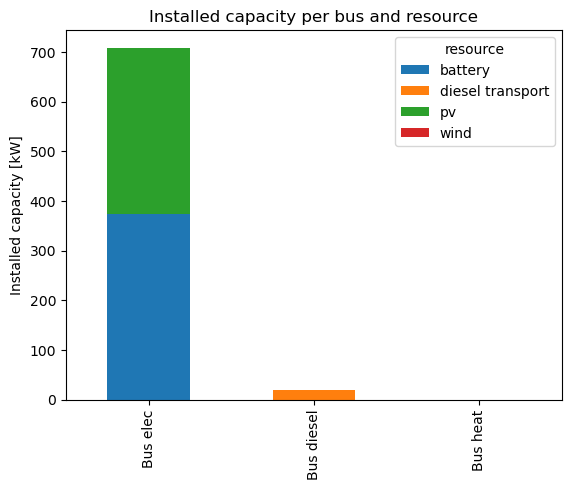

In [68]:
grouped_data = pd.concat([
    n.generators.groupby(["bus", n.generators.index.rename("resource")]).p_nom_opt.sum(),
    n.storage_units.groupby(["bus", n.storage_units.index.rename("resource")]).p_nom_opt.sum(),
])
(
    grouped_data
    .reset_index()
    .pivot(index="bus", columns="resource")
    .reindex(n.buses.index)
    .droplevel(0, axis=1)
    .plot(
        kind="bar",
        stacked=True,
        ylabel="Installed capacity [kW]",
        title="Installed capacity per bus and resource",
        xlabel="",
    )
)

### 5.3 Collect major energy statistics

In the following, the goal is to collect major statistics on the total energy produced to supply the load.

Note that the time series of any quantity of the different objects is stored into the object `{object}_t`, where `{object}` is any pypsa component, such as generators, links, etc.

To do this, we first create a dataframe that contains all time series for any object and then we sum the quantities to identify the desired quantities.

In [69]:
all_dispatch = pd.concat(
    [
        n.generators_t.p,
        n.storage_units_t.p,
        n.stores_t.p,
    ],
    axis=1,
)

total_dispatch = all_dispatch.sum()

Let's compare the quantities with respect to the total demand

In [70]:
total_demand = n.loads_t.p_set.values.sum()

total_dispatch/total_demand

pv                  5.702809e-01
wind                0.000000e+00
diesel transport    4.962114e-01
battery            -1.466988e-18
dtype: float64

Let's now check the total renewable curtailment by comparing the available renewable production versus the actual production.

In [71]:
# get RES technologies that are actually installed
existing_RES_techs = n.generators.index.intersection(["pv", "wind"])

total_available_RES = n.generators_t.p_max_pu[existing_RES_techs].sum() * n.generators.p_nom_opt[existing_RES_techs]
total_available_RES

Generator
pv      509588.107712
wind         0.000000
dtype: float64

In [72]:
RES_curtailment = total_available_RES - total_dispatch[existing_RES_techs]

RES_curtailment/total_available_RES

Generator
pv      0.631411
wind         NaN
dtype: float64

### 5.4 Plot the energy dispatch

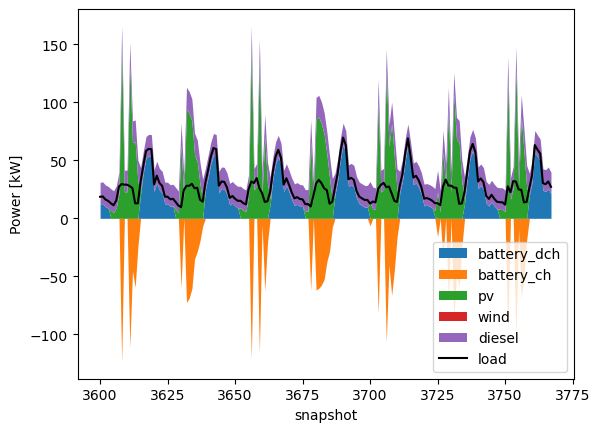

In [74]:
# Day to start the plotting from
init_day_plot = 150
# Number of days to plot
n_days_to_plot = 7

subset_sns = n.generators_t.p.index[init_day_plot*24:(init_day_plot*24 + n_days_to_plot*24)]

cols = n.generators_t.p.columns.difference(["diesel transport"])

# collect discharge power of storages
p_dch_stores = n.storage_units_t.p.loc[subset_sns, :].clip(lower=0.0)  # negative values become 0.0
p_dch_stores.columns = p_dch_stores.columns + "_dch"

# collect charge power of storages
p_ch_stores = n.storage_units_t.p.loc[subset_sns, :].clip(upper=0.0)  # positive values become 0.0
p_ch_stores.columns = p_ch_stores.columns + "_ch"

# create a dataframe to plot the quantities to plot
data_to_plot = pd.concat(
    [
        p_dch_stores,
        p_ch_stores,
        n.generators_t.p.loc[subset_sns, cols],
        n.links_t.p0.loc[subset_sns, :],
    ],
    axis=1,
)


ax = data_to_plot.plot.area(linewidth=0.0) #, figsize=FIGSIZE)

plt.plot(df_data.loc[subset_sns, ["elec_demand"]].sum(axis=1), label="load", color="k")
plt.ylabel("Power [kW]")
plt.legend()

### 5.6 Plot the diesel transport and electricity production

Text(0, 0.5, 'Power [kW]')

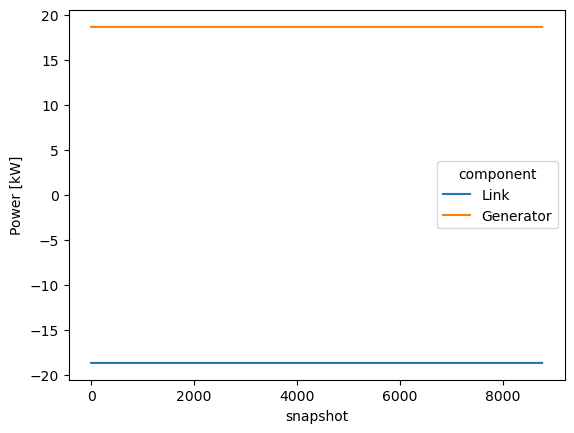

In [75]:
st_buses = n.statistics.energy_balance(aggregate_time=False, groupby=["bus"]).fillna(0.)

st_buses.query("bus == 'Bus diesel'").droplevel(1).T.plot()
plt.ylabel("Power [kW]")

Text(0, 0.5, 'Power [kW]')

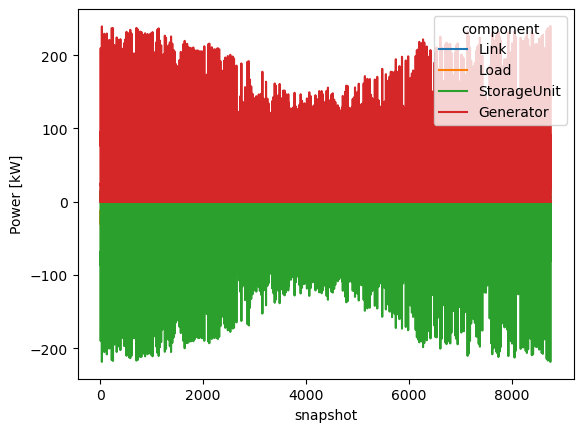

In [77]:
st_buses.query("bus == 'Bus elec'").droplevel(1).T.plot()
plt.ylabel("Power [kW]")